In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [2]:
db=mysql.connector.connect(host="localhost",
                          username="root",
                          password='sql@123',
                          database='ecommerce')
cur=db.cursor()

In [3]:
# 1.List all unique cities where customers are located.

query=''' select distinct customer_city from customers'''
cur.execute(query)
data=cur.fetchall()
#data
df = pd.DataFrame(data,columns=['customer_city'])
df

,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


In [4]:
# 2.Count the number of orders placed in 2017.
query=''' select count(order_id) from orders
          where year(order_purchase_timestamp)=2017'''
cur.execute(query)
data=cur.fetchall()
#df=pd.DataFrame(data)
print('number of orders placed in 2017:',data[0][0])

number of orders placed in 2017: 45101


In [5]:
# 3.Find the total sales per category
query='''select upper(products.product_category) category,
        round(sum(payments.payment_value),2) sales
        from products join order_item
        on products.product_id=order_item.product_id
        join payments
        on payments.order_id=order_item.order_id
        group by category
        '''
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Category','Sales'])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


In [6]:
# 4.Calculate the percentage of orders that were paid in installments
query=''' select 
                (sum(case when payment_installments >=1 then 1 else 0 end)*100)/count(*)from payments as percentage_count
    '''
cur.execute(query)
data=cur.fetchall()
print('the percentage of orders that were paid in installments is',data[0][0])

the percentage of orders that were paid in installments is 99.9981


In [7]:
# 5.Count the number of customers from each state.
query='''select customer_state,count(customer_id)from customers
        group by customer_state'''
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["state","customer_count"])
df=df.sort_values(by='customer_count',ascending=False)
df

,state,customer_count
0,SP,41746
4,RJ,12852
2,MG,11635
5,RS,5466
3,PR,5045
1,SC,3637
9,BA,3380
13,DF,2140
8,ES,2033
7,GO,2020


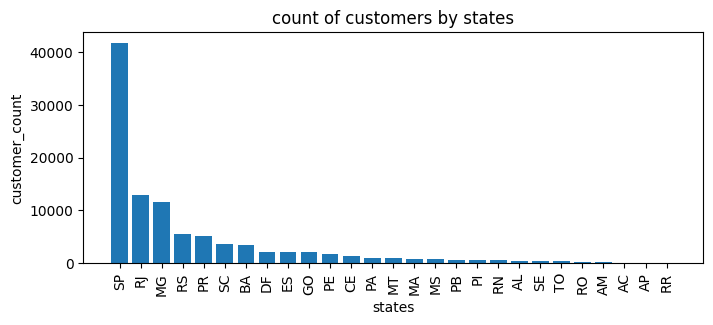

In [8]:
plt.figure(figsize=(8,3))
plt.bar(df['state'],df['customer_count'])
plt.xticks(rotation=90)
plt.xlabel('states')
plt.ylabel('customer_count')
plt.title('count of customers by states')
plt.show()

In [9]:
# 6.Calculate the number of orders per month in 2018
query=''' select monthname(order_purchase_timestamp)as month,count(order_id)from orders
        where year(order_purchase_timestamp)=2018 
        group by month
'''
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["month_name","order_count"])
df

,month_name,order_count
0,July,6292
1,August,6512
2,February,6728
3,June,6167
4,March,7211
5,January,7269
6,May,6873
7,April,6939
8,September,16
9,October,4


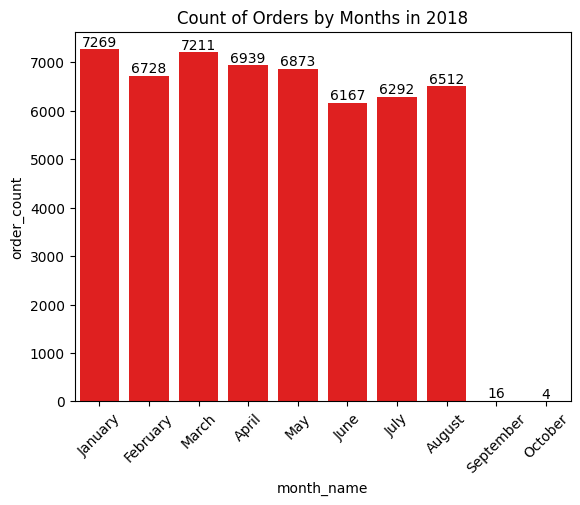

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

o = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]
ax = sns.barplot(x=df["month_name"], y=df["order_count"], data=df, order=o, color="red")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months in 2018")
plt.show() 


In [11]:
# 7.Find the average number of products per order, grouped by customer city

query='''with count_per_order as(
    select orders.order_id,orders.customer_id,count(order_item.order_id) as oc
    from orders join order_item
    on orders.order_id=order_item.order_id
    group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2) as average_orders
from customers join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city order by average_orders desc
'''
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer_city", "average products_per_order"])
df.head(10)



,customer_city,average products_per_order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


In [12]:
# 8.Calculate the total revenue generated by each seller, and rank them by revenue.
query='''select*,dense_rank() over(order by revenue desc)as rn from
(select order_item.seller_id,sum(payments.payment_value) as revenue 
    from order_item join payments
    on order_item.order_id = payments.order_id
    group by order_item.seller_id)as a'''

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['seller_id','revenue','rank'])
df=df.head(5)
df

,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5


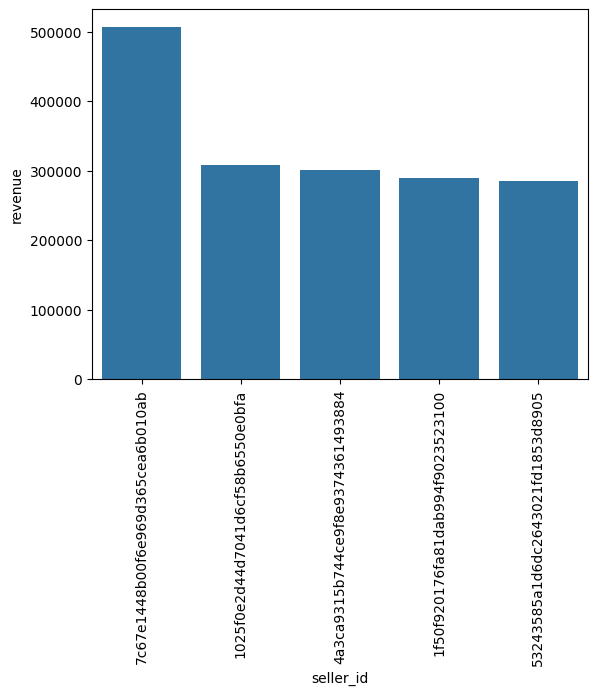

In [13]:
sns.barplot(x='seller_id',y='revenue',data=df)
plt.xticks(rotation=90)
plt.show()

In [14]:
#9.Calculate the percentage of total revenue contributed by each product category.
query='''select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_item on products.product_id=order_item.product_id
join payments on payments.order_id=order_item.order_id
group by category order by sales_percentage desc



'''
cur.execute(query)
data=cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


In [15]:
#10.Identify the correlation between product price and the number of times a product has been purchased
query='''select products.product_category as category,
count(order_item.product_id),
round(avg(order_item.price),2)
from products join order_item
on products.product_id =order_item.product_id
group by category'''

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['categoty','order_count','price'])
arr1=df['order_count']
arr2=df['price']
import numpy as np
a=np.corrcoef([arr1,arr2])
print('The correlation is',a[0][-1])

The correlation is -0.10631514167157562


In [16]:
#11.Calculate the moving average of order values for each customer over their order history.
query='''select customer_id,
        order_purchase_timestamp,
        payment,
        avg(payment) over(partition by customer_id order by order_purchase_timestamp
        rows between 2 preceding and current row) as mov_avg
from 
(select orders.customer_id,orders.order_purchase_timestamp,
        payments.payment_value as payment
from payments join orders
on payments.order_id=orders.order_id)as a
'''

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['customer_id','purchase_timestamp','payment','moving_avg'])
df.head(50)


,customer_id,purchase_timestamp,payment,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.80,71.800003
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.40,49.400002
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.59,166.589996
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.23,85.230003
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.71,1255.709961


In [17]:
# 12.Calculate the cumulative sales per month for each year.
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['years', 'months', 'payment', 'Cumulative_sales'])
df

,years,months,payment,Cumulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


In [18]:
# 13.Calculate the year-over-year growth rate of total sales.
query='''with a as(select year(orders.order_purchase_timestamp) as years,
            round(sum(payments.payment_value),2) as payment from orders join payments
            on orders.order_id=payments.order_id
            group by years order by years)
select years,((payment-lag(payment,1) over (order by years))/ 
lag(payment,1) over(order by years))*100 from a'''

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['years','yoy% growth'])
df

,years,yoy% growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


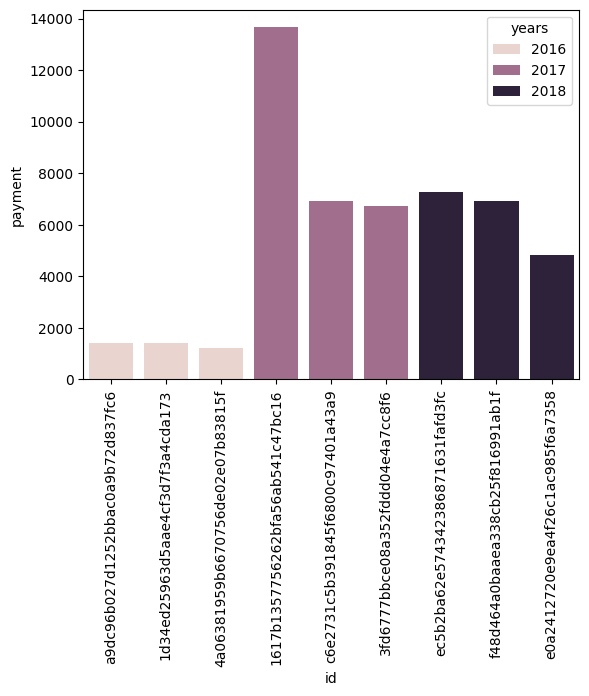

In [19]:
# 14.Identify the top 3 customers who spent the most money in each year.
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()
